# 3.7.2: Baseball

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In the previous notebook we developed a model of the flight of a
baseball.  In this notebook we apply that model to an optimization problem. In  this chapter we'll find the angle you should hit a baseball to maximize the distance it travels. And we'll use a new function, called `minimize_scalar` that searches for this angle efficiently.

Here's the code from the previous notebook:

In [ ]:
# @title
import pandas as pd
import numpy as np

def angle_to_x(mag,angle):
    theta = np.deg2rad(angle)
    x = mag * np.cos(theta)
    return x

def angle_to_y(mag,angle):
    theta = np.deg2rad(angle)
    y = mag * np.sin(theta)
    return y

def unit_vec(V, mag):
    return  V/mag

def drag_force(V, system):
    rho, C_d, area = system['rho'], system['C_d'], system['area']

    # Find the magnitude and direction of the velocity
    vel_mag = np.sqrt(V.x**2 + V.y**2)
    if vel_mag != 0:
        dir = unit_vec(V, vel_mag)
    else:
        dir = pd.Series(dict(x = 0, y = 0), dtype = float)

    # Find the magnitude of the drag force
    drag_mag = rho * vel_mag**2 * C_d * area * (1/2)

    # Define the direction of the force as opposite that of the  velocity
    # Notice that "dir" is a vector, so f_drag is vector too
    f_drag = drag_mag * -dir

    return f_drag

def change_func(t, state, system):
    x, y, vx, vy = state
    mass, g, dt = system['mass'], system['g'], system['dt']

    V = pd.Series(dict(x=vx, y=vy),dtype=float)
    a_drag = drag_force(V, system) / mass

    # Acceleration has to be defined as a vector too
    a_grav = pd.Series(dict(x=0,y=-g),dtype=float)

    A = a_grav + a_drag

    x = x + V.x*dt
    y = y + V.y*dt
    vx = vx + A.x*dt
    vy = vy + A.y*dt

    return pd.Series(dict(x=x, y=y, vx=vx, vy=vy))

def run_simulation(system, state, change_func):
    # Define the time steps
    t_array = np.arange(0, system['t_end']+1, system['dt'])
    n = len(t_array)

    # Set up a DataFrame to store the our state variables
    results = pd.DataFrame(index=t_array, columns=state.index,
                        dtype=np.float64)
    results.iloc[0] = state

    for i in range(n-1):
        t = t_array[i]
        state = change_func(t, state, system)
        results.iloc[i+1] = state
        # Test to see if the penny has hit the ground
        if state.y <= 0.0:
            results = results.dropna()
            return results

    return results

def plot_trajectory(results,label,**options):
    x = results.x.values
    y = results.y.values
    x_vs_y = pd.Series(data=y,index=x)
    x_vs_y.plot(label=label,xlabel='x position (m)',
             ylabel='y position (m)',figsize=[9,3],**options)

## Optimizing a baseball flight

There has long been a debate among baseball players and coaches about how the angle of approach of a baseball swing.  Should a player swing "up" on the ball in an attempt to increase the launch angle of the ball?  Or is it better to make a level swing that drives the ball in a horizontal direction?

<br>

We're probably not going to solve that argument, but we can at least make a contribution.  What launch angle will actually produce the longest fly ball?

### Creating a system

We're going to use the simulation that we developed in the exercise of the previous notebook and a function called `minimize_scalar` to find an answer.  We'll start with a system, which will now include the initial values for `x` and `y` as well as `speed` and `angle` so we can repeatedly create new states in our simulation

In [ ]:
# Initial state variables
x_init = 0           # m
y_init = 1           # m
angle = 45      # degree
speed = 40      # m / s

# System parameters
mass = 0.145    # kg
diam = 0.073    # m
C_d = 0.33      # dimensionless
rho = 1.2       # kg/m**3
g = 9.8         # m/s**2

# Simulation parameters
t_end = 10      # s
dt = 0.01        # s

system = dict(x_init =x_init, y_init=y_init, C_d=C_d,
              rho=rho, g=g, t_end=t_end, speed=speed, angle=angle,
                mass=mass, area = np.pi * (diam/2)**2, dt=dt)



---

<br>

🟨 🟨 Active Reading

A projectile without drag will achieve its maximum distance when launched at a 45 degree angle.  When we include drag, do you think the optimal angle will be at, above or below 45 degrees?  Why?  


✅ ✅ Put your answer here.

### Optimizing by sweeping through a parameter

We want to find the launch angle that maximizes the *range*, that is, the distance the ball travels in the air before landing. We'll use a function in a SciPy function called `minimize_scalar`, which takes a function and finds its minimum.  It might seem odd to use a "minimize" function to find the maximum range, but minimization problems are easier to formulate than maximization problems, and so computer algorithms are often designed to minimize.  As we'll see, it's easy enough to use a minimization algorithm to maximize a value (i.e. a scalar).

<br>

The function we pass to `minimize_scalar` should take launch angle in degrees, simulate the flight of a ball launched at that angle, and return the distance the ball travels along the $x$ axis.

In [ ]:
def range_func(angle, system):
    # Unpack the necessary variables
    x_init, y_init = system['x_init'], system['y_init']
    speed = system['speed']

    # Create a new initial state with 'angle' from the argument
    state = pd.Series(dict(x=x_init, y=y_init,
                       vx=angle_to_x(speed, angle),
                       vy=angle_to_y(speed, angle)))
    results = run_simulation(system, state, change_func)

    # Find the maximum distance travelled
    x_dist = results.iloc[-1].x
    return -x_dist

`range_func` makes a new State object with the given value of
`angle`. Then runs the simulation and
returns the final value of `x` from the results.  In short, it tells us how far a ball will travel at the angle and speed given by the argument.  Notice that since we want to *maximize* our function, we're multiplying `x_dist` by -1: this means that the "minimum" value of the function will actually be the largest $x$ value.

<br>

We can call `range_func` directly like this:

In [ ]:
range_func(45, system)

-99.53983641660302

With launch angle 45°, the ball lands about 99.5 meters from home plate.  Test the prediction you made above: about what angle produces the longest distance?

<br>

Now we can sweep a sequence of angles like this:

In [ ]:
# Define the angles we will test
angles = np.linspace(20, 80, 21)

# Create a Series to hold our results
sweep = pd.Series([],dtype=np.float64)

# Run a simulation at all the test angles and save the results
for angle in angles:
    x_dist = range_func(angle, system)
    sweep[angle] = x_dist

We ran 21 simulations, so it takes a little bit more time!
 Here's what the results look like.

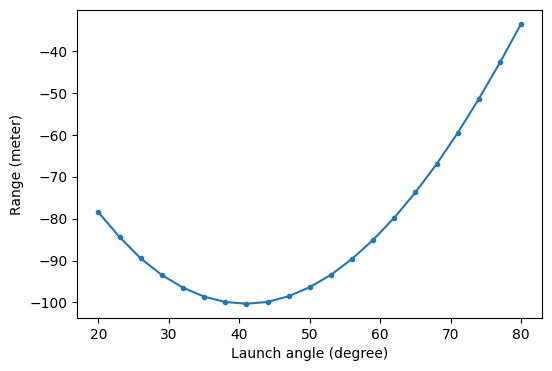

In [ ]:
sweep.plot(xlabel='Launch angle (degree)',
         ylabel='Range (meter)',marker='.', figsize = [6,4]);

The dots represent actual data points determined by `range_func`.  



---

<br>

🟨 🟨 Active Reading

What is the optimized angle, approximately?  Is this closer to a line drive or a pop fly?  Compare this to the guess you made above, and discuss any errors you might have made in your guess.


✅ ✅ Put your answer here.

---

### Optimizing by using a "black box" function

To find the optimal angle more precisely and more efficiently, we can use a SciPy algorithm called `minimize_scalar`.  Notice that range function has two arguments: "angle" and "system".  When `minimize_scalar` is called, it will attempt to minimize the value of the `range_func` by sweeping through possible values for the first argument in the `range_func`, which in our case is "angle".  

<br>

Library functions like this are sometimes called "black box" functions, because we can't see what is actually being done to the inputs to create the outputs.  But they are also often fast, efficient, and accurate:

In [ ]:
import scipy.optimize as spo
res = spo.minimize_scalar(range_func, args=system)

The first parameter is `range_func`, the function we want to minimize.  `args` is a *keyword argument* that allows us to pass `system` on to `range_func`.

<br>

<center>

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/3_7/oneline.PNG width = 300>

</center>

<br>

The return value from `minimize_scalar` is an object that contains the
results, including `x`, which is the angle that yielded the maximum
range, and `fun`, which is the function value at that angle (i.e. the distance the ball travels when the ball is launched at the optimal angle).

In [ ]:
res

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -100.3909008731405
       x: 40.568809936407035
     nit: 30
    nfev: 38

In [ ]:
print("When hit at an angle of", round(res.x,2), ", the ball travels", -round(res.fun,2), "meters")

When hit at an angle of 40.57 , the ball travels 100.39 meters


For these parameters, the optimal angle is about 40.5°, which yields a range of over 100 m.


---

<br>

🟨 🟨 Active Reading: Matching (Submit "Definition" letters in order of "Terms", separated by a space)


In [ ]:
import pandas as pd
import numpy as np
from urllib.request import urlretrieve

location = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/'
folder = 'Support_files/'
name = 'Embedded_Qs.ipynb'
local, _ = urlretrieve(location + folder + name, name)
%run /content/$name

#@title { form-width: "50%", display-mode: "form" }
home = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Embedded_Qs/'
data, number = display_match('3_7_2D', home,3)
answer = "" #@param {type:"string"}
a = answer.split(sep=" ")
check_match(data,a, number)



We found the optimal launch angle in two ways: by manually sweeping through the "angle" parameter, and by using the SciPy function "minimize_scalare".   Choose which of those options has the advantage in each of the following categories.

Terms

1) Accuracy of the answer
2) Number of lines of code necessary to implement the method
3) Speed of calculation
4) Ease of fixing errors that arise
5) Ease of understanding exactly what is happening in the code

Definitions

A) Manual sweeping is better for this
B) A "black box" library function like "minimize_scalar" is better for this


---

## Exercises

---

<br>

🟨 🟨

### Exercise 1

Baseball players don't just want to hit the ball far: they want to hit it high enough to get over the outfield fence.   Describe what you could do to the code to find the distance $x$ that the ball could clear the fence.  Be specific about what you which function need to change and how (change function, drag force function, range_func, run_simulation, etc...).



✅ ✅  Put your answer here.